In [1]:
import os
import cv2
import glob
import dlib
import math
import numpy as np
from cv2 import *
from typing import List, Tuple
from imutils import face_utils
from collections import defaultdict
import matplotlib.pyplot as plt

# 1. Correspondence
Find some corresponding face landmarks between start and end images and display them (10 points). This
can either be done manually, or using an automatic facial landmark detector, to find salient points such as on
the eyebrows, corners of the eyes etc.<br><br>
An example of a landmark detector is dlib which provides 68 facial landmarks on the eyes, nose, mouth,
eye-brows and jaw. You could even add a few more points manually.<br><br>
We would recommend that you debug on a smaller number of points and once you are sure your algorithm
works add more to increase the quality.

Number of faces detected: 1
Detection 0: Left: 77 Top: 139 Right: 262 Bottom: 325
Part 0: (74, 194), Part 1: (77, 219) ...
Number of faces detected: 1
Detection 0: Left: 68 Top: 142 Right: 291 Bottom: 365
Part 0: (79, 211), Part 1: (81, 237) ...


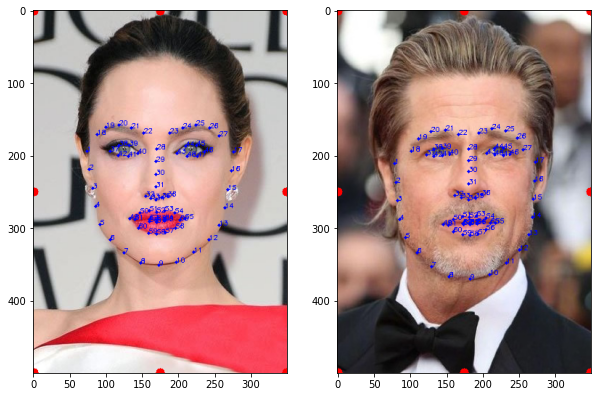

In [2]:
predictor_path = "shape_predictor_68_face_landmarks.dat"
faces_folder_path = "./"

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(predictor_path)

plt.figure(figsize=(10, 10))

for i, f in enumerate(glob.glob(os.path.join(faces_folder_path, "*.jpg"))):
    img = dlib.load_rgb_image(f)

    dets = detector(img, 1)
    print("Number of faces detected: {}".format(len(dets)))
    
    for k, d in enumerate(dets):
        print("Detection {}: Left: {} Top: {} Right: {} Bottom: {}".format(
            k, d.left(), d.top(), d.right(), d.bottom()))
        # Get the landmarks/parts for the face in box d.
        shape = predictor(img, d)
        print("Part 0: {}, Part 1: {} ...".format(shape.part(0),
                                                  shape.part(1)))
        
        # Draw the face landmarks on the screen.
        for j, part in enumerate(shape.parts()):
            cv2.circle(img, (part.x, part.y), 2, (0, 0, 255), -1)
            cv2.putText(img, str(j+1),  (part.x, part.y), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0, 0, 255), 1)
        
        # Add more 8 points(shown as red point), which are the corners and mid-point of each side
        for (x, y) in [(1, 1), (349, 499), (349, 1), (1, 499), (175, 1), (175, 499), (1, 250), (349, 250)]:
            cv2.circle(img, (x, y), 6, (255, 0, 0), -1)

        plt.subplot(1, 2, i+1)
        plt.imshow(img)
        
plt.show()

# 2. Mesh (20 points)
Create a triangulation (10 points) and visualise it (10 points). Again, you can do this manually or you can
use the standard Delaunay Triangulation algorithm to do it automatically.<br><br>
Your output should be a list of 2D triangle vertices for each image. The order of the triangles and the vertices
should reflect the correspondences between triangles and vertices.

In [3]:
predictor_path = "shape_predictor_68_face_landmarks.dat"

detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(predictor_path)

def get_face_landmark(face_img: str) -> List[List[Tuple]] and List[defaultdict]:
    if isinstance(face_img, str):
        img = dlib.load_rgb_image(face_img)
    elif isinstance(face_img, np.ndarray):
        img = face_img
    
    out1, out2 = [], []
    dets = detector(img, 1)
    for k, d in enumerate(dets):
        _face_point = []
        _out_dict = defaultdict(int)
        shape = predictor(img, d)
        for i, part in enumerate(shape.parts()):
            _face_point.append((part.x, part.y))
            _out_dict[(part.x, part.y)] = i

        # Add more 8 points shown as red point
        i = 68
        for (x, y) in [(1, 1), (349, 499), (349, 1), (1, 499), (175, 1), (175, 499), (1, 250), (349, 250)]:
            _face_point.append((x, y))
            _out_dict[(x, y)] = i
            i += 1
        out1.append(_face_point)
        out2.append(_out_dict)
    
    return out1, out2

def delaunay_triangulation(face_img, is_show=True) -> List[List[List]]:
    if isinstance(face_img, str):
        if os.path.exists(face_img):
            img = dlib.load_rgb_image(face_img)
        else:
            raise IOError("the image '{}' dose not exist.".format(face_img))
    elif isinstance(face_img, np.ndarray):
        img = face_img
    else:
        raise ValueError("please make sure the input type should be 'str'(image path) or 'numpy.ndarray'(read image).")
    
    faces, landmark_dicts = get_face_landmark(face_img)
    
    out1, out2 = [], []
    for points, landmark_dict in zip(faces, landmark_dicts):
        rect = (0, 0, img.shape[1], img.shape[0])  # Rectangle to be used with Subdiv2D
        subdiv = cv2.Subdiv2D(rect)  # Create an instance of Subdiv2D
    
        # Insert points into subdiv
        for p in points:
            subdiv.insert(p)

        triangle_vertices_list = np.array(subdiv.getTriangleList(), dtype=int).tolist()
        for _tri in triangle_vertices_list:
            out2.append([landmark_dict[tuple(_tri[:2])], landmark_dict[tuple(_tri[2:4])], landmark_dict[tuple(_tri[4:])]])
        out1.append(triangle_vertices_list)
        
        if is_show:
            plt.figure(figsize=(10, 10))
            for i, t in enumerate(triangle_vertices_list):
                pt1 = (t[0], t[1])  # first vertice coordinate
                pt2 = (t[2], t[3])  # second vertice coordinate
                pt3 = (t[4], t[5])  # third vertice coordinate
                p_center = (int((t[0]+t[2]+t[4])/3), int((t[1]+t[3]+t[5])/3))

                cv2.line(img, pt1, pt2, (255, 255, 255), 1, 8, 0)
                cv2.line(img, pt2, pt3, (255, 255, 255), 1, 8, 0)
                cv2.line(img, pt3, pt1, (255, 255, 255), 1, 8, 0)
#                 cv2.circle(img, p_center, 2, (0, 0, 255), -1)
#                 cv2.putText(img, str(i+1), p_center, cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0, 0, 255), 1)
                
            plt.imshow(img)
            plt.show()

    return out1, out2

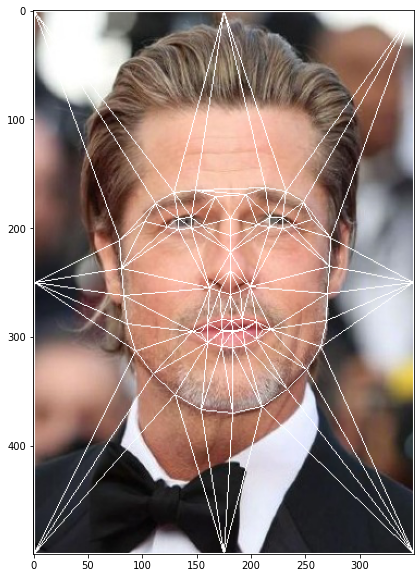

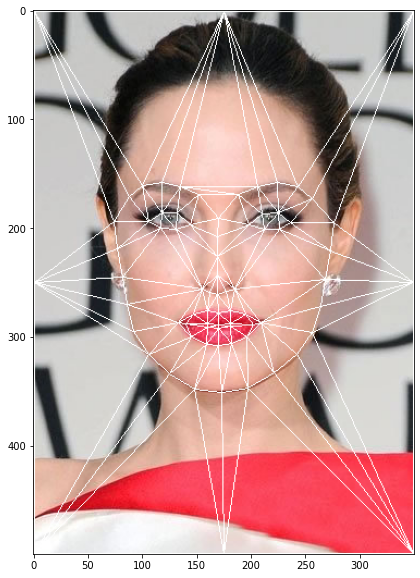

In [4]:
delaunay_triangulation_start, tri_index = delaunay_triangulation("start.jpg")
delaunay_triangulation_end, _ = delaunay_triangulation("end.jpg")

In [5]:
# print out first few rows of 2D triangle vertices list of 'start.jpg'
# each row 'r' represents coordinates of three vertices of each triangle
# e.g. r = [231, 206, 205, 213, 216, 184], 
#      (r[0]=231, r[1]=206) represents first vertice coordinate
#      (r[2]=205, r[3]=213) represents second vertice coordinate
#      (r[4]=216, r[5]=184) represents third vertice coordinate
delaunay_triangulation_start[0][:5]  # 0 index means first face triangulation result

[[102, 194, 81, 237, 79, 211],
 [81, 237, 102, 194, 123, 199],
 [83, 262, 1, 250, 81, 237],
 [1, 250, 83, 262, 86, 288],
 [81, 237, 1, 250, 79, 211]]

In [6]:
# print out first few rows of the index of each triangle vertices
# e.g. the first triangle is represented by [29, 40, 39],
#      and its first vertice index is 29, 
#      and the index 29 means the 29-th landmark of the 68s
tri_index[:5]

[[17, 1, 0], [1, 17, 36], [2, 74, 1], [74, 2, 3], [1, 74, 0]]

# 3. Blending with a mesh (20 points)
Create the intermediate image coordinates in all “in between” images for all the vertices of all triangles by
linearly interpolating between the start and end positions. For every pair of corresponding triangles, take the
3 pairs of corresponding vertices and estimate an affine warp (20 points). You will need to solve a linear
system of equations to estimate the parameters of the affine warp. You must write the code for this function
yourself. Do not use a built-in function for this. Map all corresponding points between the triangles. This
means, find the new coordinates for all the points in the triangle (before you only knew the position of the 3
vertices, with the affine transformation you can find all the correspondences!). Remember to use the inverse
warp instead of the forward warp and use bilinear interpolation.通过在开始和结束位置之间线性插值，在所有“中间”图像中为所有三角形的所有顶点创建中间图像坐标。对于每一对对应的三角形，取3对对应的顶点，并估计一个仿射经线(20点)。你需要解一个线性方程组来估计仿射经线的参数。您必须自己编写这个函数的代码。不要为此使用内置函数。映射三角形之间的所有对应点。这意味着，找到三角形中所有点的新坐标(以前你只知道3个顶点的位置，通过仿射变换你可以找到所有的对应关系!)记住，使用反向扭曲而不是正向扭曲，并使用双线性插值。<br><br>
You must write the code for this function yourself. You must build your own function that takes in pairs of
corresponding points and returns the parameters of the affine transformation. You can use a built-in function
to determine if a point is inside a triangle or not. You may use built in functions for matrix operations such
as: multiplying matrices, computing the inverse of a matrix, transpose etc. . .您必须自己编写这个函数的代码。您必须构建自己的函数，该函数接受对对应的点并返回仿射变换的参数。您可以使用内置函数来确定一个点是否在三角形内。你可以使用内置函数进行矩阵运算，如:矩阵相乘，计算矩阵的逆，转置等。<br><br>
You may not use built in functions from OpenCV or any other library for this. You may not use the
applyaffine built-in function. You may not use an existing function, to estimate the parameters of the
affine transform given a set of corresponding points. You may not use the estimated affine transformations to
warp the triangles using bilinear interpolation to create the intermediate images
你不能使用来自OpenCV或任何其他库的内置函数。您不能使用applyaffine内置函数。你不能使用一个已有的函数，来估计仿射变换的参数给定一组对应的点。你不能使用估计的仿射变换来扭曲三角形，使用双线性插值来创建中间图像

In [7]:
# # Apply affine transform calculated using srcTri and dstTri to src and
# # output an image of size.
# def applyAffineTransform(src, srcTri, dstTri, size) :
    
#     # Given a pair of triangles, find the affine transform.
#     warpMat = cv2.getAffineTransform(np.float32(srcTri), 
#                                      np.float32(dstTri))
    
#     # Apply the Affine Transform just found to the src image
#     dst = cv2.warpAffine(src, 
#                          warpMat, 
#                          (size[0], size[1]), 
#                          None, 
#                          flags=cv2.INTER_LINEAR, 
#                          borderMode=cv2.BORDER_REFLECT_101)

#     return dst


# # Warps and alpha blends triangular regions from img1 and img2 to img
# def morph_triangle(img_start, img_end, img_morph, t1, t2, t, alpha) :

#     # Find bounding rectangle for each triangle
#     r1 = cv2.boundingRect(np.float32([t1]))
#     r2 = cv2.boundingRect(np.float32([t2]))
#     r = cv2.boundingRect(np.float32([t]))

#     # Offset points by left top corner of the respective rectangles
#     t1Rect = []
#     t2Rect = []
#     tRect = []

#     for i in range(0, 3):
#         tRect.append(((t[i][0] - r[0]),(t[i][1] - r[1])))
#         t1Rect.append(((t1[i][0] - r1[0]),(t1[i][1] - r1[1])))
#         t2Rect.append(((t2[i][0] - r2[0]),(t2[i][1] - r2[1])))

#     # Get mask by filling triangle
#     mask = np.zeros((r[3], r[2], 3), dtype = np.float32)
#     cv2.fillConvexPoly(mask, np.int32(tRect), (1.0, 1.0, 1.0), 16, 0);

#     # Apply warpImage to small rectangular patches
#     img1Rect = img_start[r1[1]:r1[1] + r1[3], r1[0]:r1[0] + r1[2]]
#     img2Rect = img_end[r2[1]:r2[1] + r2[3], r2[0]:r2[0] + r2[2]]

#     size = (r[2], r[3])
#     warpImage1 = applyAffineTransform(img1Rect, t1Rect, tRect, size)
#     warpImage2 = applyAffineTransform(img2Rect, t2Rect, tRect, size)

#     # Alpha blend rectangular patches
#     imgRect = (1.0 - alpha) * warpImage1 + alpha * warpImage2

#     # Copy triangular region of the rectangular patch to the output image
#     img_morph[r[1]:r[1]+r[3], r[0]:r[0]+r[2]] = img_morph[r[1]:r[1]+r[3], r[0]:r[0]+r[2]] * (1 - mask) + imgRect * mask

## 3.1. solve affine transform matrix
1. solve a linear system of equations to estimate the parameters of the affine warp<br><br>
2. Estimating the color of each point by mapping the corresponding triangles with the estimated affine transform
and using bilinear interpolation

In [8]:
def getAffineTranssform(fp, tp):
    """ Find affine transformation matrix, such that 
        tp is affine transf of fp. """
    
    # condition points
    # --from points--
    m = np.mean(fp[:2], axis=1)
    maxstd = max(np.std(fp[:2], axis=1)) + 1e-9
    C1 = np.diag([1/maxstd, 1/maxstd, 1]) 
    C1[0][2] = -m[0]/maxstd
    C1[1][2] = -m[1]/maxstd
    fp_cond = np.dot(C1,fp)
    
    # --to points--
    m = np.mean(tp[:2], axis=1)
    C2 = C1.copy() #must use same scaling for both point sets
    C2[0][2] = -m[0]/maxstd
    C2[1][2] = -m[1]/maxstd
    tp_cond = np.dot(C2,tp)
    
    # conditioned points have mean zero, so translation is zero
    A = np.concatenate((fp_cond[:2],tp_cond[:2]), axis=0)
    U,S,V = np.linalg.svd(A.T)
    
    # create B and C matrices as Hartley-Zisserman (2:nd ed) p 130.
    tmp = V[:2].T
    B = tmp[:2]
    C = tmp[2:4]
    
    tmp2 = np.concatenate((np.dot(C,np.linalg.pinv(B)),np.zeros((2,1))), axis=1) 
    H = np.vstack((tmp2,[0,0,1]))
    
    # decondition
    H = np.dot(np.linalg.inv(C2),np.dot(H,C1))
    H = H / H[2,2]

    return H[:2]

def invert_affine_ransform(matrix):
    """
    :param matrix: shape[2, 3]. float32
    :return: shape[2, 3]
    """
    matrix = np.concatenate([matrix, np.array([0, 0, 1], dtype=matrix.dtype)[None]])  # for inv
    return np.linalg.inv(matrix)[:2]

def bilinear_interpolation(img,dstH,dstW):
    scrH,scrW,_ = img.shape
    img = np.pad(img,((0,1),(0,1),(0,0)),'constant')
    retimg = np.zeros((dstH,dstW,3),dtype=np.uint8)
    for i in range(dstH):
        for j in range(dstW):
            scrx = (i+1)*(scrH/dstH)-1
            scry = (j+1)*(scrW/dstW)-1
            x=math.floor(scrx)
            y=math.floor(scry)
            u=scrx-x
            v=scry-y
            retimg[i,j]=(1-u)*(1-v)*img[x,y] + u*(1-v)*img[x+1,y] + (1-u)*v*img[x,y+1] + u*v*img[x+1,y+1]
    return retimg

def warp_affine(x, matrix, dsize=None):
    """
    :param x: shape[H, W, C]. uint8
    :param matrix: affine matrix. shape[2, 3]. float32
    :param dsize: Tuple[W, H]. output size
    :return: shape[dsize[1], dsize[0], C]. uint8
    """
    dsize = dsize or (x.shape[1], x.shape[0])  # output size
    borderValue = np.array((114, 114, 114), dtype=x.dtype)  # background fulfilling
    matrix = invert_affine_ransform(matrix)

    grid_x, grid_y = np.meshgrid(np.arange(dsize[0]), np.arange(dsize[1]))  # np.int32
    src_x = (matrix[0, 0] * grid_x + matrix[0, 1] * grid_y + matrix[0, 2]).round().astype(np.int32)  # X
    src_y = (matrix[1, 0] * grid_x + matrix[1, 1] * grid_y + matrix[1, 2]).round().astype(np.int32)  # Y
    src_x_clip = np.clip(src_x, 0, x.shape[1] - 1)
    src_y_clip = np.clip(src_y, 0, x.shape[0] - 1)

#     output = np.where(((0 <= src_x) & (src_x < x.shape[1]) & (0 <= src_y) & (src_y < x.shape[0]))[:, :, None],
#                       x[src_y_clip, src_x_clip], borderValue[None, None])  # broadcasting

    output = bilinear_interpolation(x[src_y_clip, src_x_clip], dsize[1], dsize[0])
    
    return output

In [9]:
def applyAffineTransform(src, srcTri, dstTri, size) :
    warpMat = getAffineTransform(np.float32(srcTri), np.float32(dstTri))

    # Apply the Affine Transform just found to the src image
    dst = warp_affine(src, warpMat, (size[0], size[1]))
    
    return dst


# Warps and alpha blends triangular regions from img1 and img2 to img
def morph_triangle(img_start, img_end, img_morph, t1, t2, t, alpha) :

    # Find bounding rectangle for each triangle
    r1 = boundingRect(np.float32([t1]))
    r2 = boundingRect(np.float32([t2]))
    r = boundingRect(np.float32([t]))

    # Offset points by left top corner of the respective rectangles
    t1Rect = []
    t2Rect = []
    tRect = []

    for i in range(0, 3):
        tRect.append(((t[i][0] - r[0]),(t[i][1] - r[1])))
        t1Rect.append(((t1[i][0] - r1[0]),(t1[i][1] - r1[1])))
        t2Rect.append(((t2[i][0] - r2[0]),(t2[i][1] - r2[1])))

    # Get mask by filling triangle
    mask = np.zeros((r[3], r[2], 3), dtype = np.float32)
    fillConvexPoly(mask, np.int32(tRect), (1.0, 1.0, 1.0), 16, 0);

    # Apply warpImage to small rectangular patches
    img1Rect = img_start[r1[1]:r1[1] + r1[3], r1[0]:r1[0] + r1[2]]
    img2Rect = img_end[r2[1]:r2[1] + r2[3], r2[0]:r2[0] + r2[2]]
    
    size = (r[2], r[3])
    warpImage1 = applyAffineTransform(img1Rect, t1Rect, tRect, size)
    warpImage2 = applyAffineTransform(img2Rect, t2Rect, tRect, size)

    # Alpha blend rectangular patches
    imgRect = (1.0 - alpha) * warpImage1 + alpha * warpImage2

    # Copy triangular region of the rectangular patch to the output image
    img_morph[r[1]:r[1]+r[3], r[0]:r[0]+r[2]] = img_morph[r[1]:r[1]+r[3], r[0]:r[0]+r[2]] * (1 - mask) + imgRect * mask

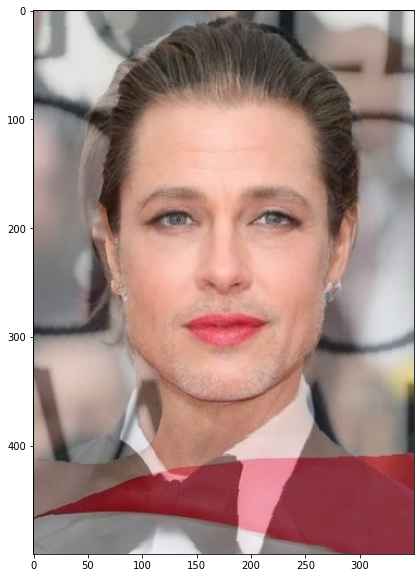

In [10]:
filename1 = 'start.jpg'
filename2 = 'end.jpg'
alpha = 0.5

# Read images
img1 = cv2.imread(filename1)
img2 = cv2.imread(filename2)

# Read corresponding points
points1 = get_face_landmark(img1)[0][0]  # [(x1, x2), ..., (x68, y68)]
points2 = get_face_landmark(img2)[0][0]
points = []

# Compute weighted average point coordinates
for i in range(len(points1)):
    x = (1 - alpha) * points1[i][0] + alpha * points2[i][0]
    y = (1 - alpha) * points1[i][1] + alpha * points2[i][1]
    points.append((int(x), int(y)))

# Allocate space for final output
imgMorph = np.zeros(img1.shape, dtype=img1.dtype)
_, tri_index = delaunay_triangulation(img1, is_show=False)

for line in tri_index:
    x, y, z = line
    t1 = [points1[x], points1[y], points1[z]]
    t2 = [points2[x], points2[y], points2[z]]
    t = [points[x], points[y], points[z]]

    # Morph one triangle at a time.
    morph_triangle(img1, img2, imgMorph, t1, t2, t, alpha)

plt.figure(figsize=(10, 10))
r,g,b = cv2.split(imgMorph)
imgMorph = cv2.merge([b,g,r])
plt.imshow(imgMorph)
plt.show()